In [121]:
import joblib
import pandas as pd
from engineering import EngineeringTransformer

import warnings
warnings.filterwarnings("ignore")

pipeline = joblib.load('../pipelines/feature_engineering_pipeline.joblib')
df = pd.read_csv("../data/train.csv")
df_val = pd.read_csv("../data/orig_valid.csv")
df_val = pipeline.transform(df_val)


# Testing models

In [122]:
y_train = df['FINALIZED_LOAN']
X_train = df.drop(columns="FINALIZED_LOAN")

y_val = df_val['FINALIZED_LOAN']
X_val = df_val.drop(columns="FINALIZED_LOAN")


In [145]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

def my_cross_validate(models, X_train, y_train, scoring, cv=6, n_jobs=-1):
    rows = len(models)
    cols = len(scoring)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), sharex=True, sharey=True)
    axes = axes.flatten()
    
    all_scores = {}
    base_results = cross_validate(DummyClassifier(strategy="uniform"), X_train, y_train, cv=cv, n_jobs=n_jobs, scoring=scoring)
    base_scores = [(name, base_results[name]) for name in base_results if name.startswith("test_")] 
    all_scores["base"] = base_scores
    
    labels = ['Fold {}'.format(i) for i in range(1, cv + 1)]
    x = np.arange(len(labels))
    width = 0.35
    
    for j, model in enumerate(models):
        cv_results = cross_validate(model, X_train, y_train, cv=cv, n_jobs=n_jobs, scoring=scoring)

        model_name = model.__class__.__name__.split(".")[-1]
        scores = [(name[len("test_"):], cv_results[name]) for name in cv_results if name.startswith("test_")] 
        all_scores[model_name] = scores
        
        for i, (name, score) in enumerate(scores):
            org_i = i
            i += j * len(scoring)
            
            mean_score = np.mean(score)
            std_score = np.std(score)
            base_score = np.mean(base_scores[org_i][1])
            
            # print(f"{name:.10s} - mean score: {mean_score:2.6f}, std: {std_score:2.6f}. Precise: {score}")

            bars = sns.barplot(x=x, y=score, ax=axes[i], color='skyblue')
            axes[i].axhline(y=mean_score, color='red', linestyle='--', label=f'Mean ({mean_score:1.3f})')
            axes[i].axhline(y=mean_score + std_score, color='orange', linestyle='--', label=f"+- std ({std_score:1.3f})")
            axes[i].axhline(y=mean_score - std_score, color='orange', linestyle='--')
            axes[i].axhline(y=base_score, color='green', linestyle='-.', label=f"Base score ({base_score:1.3f})")
            
            if org_i == 0:
                axes[i].set_ylabel(f"{model_name}")
            if j == 0:
                axes[i].set_title(f"{name}")
            axes[i].set_xticklabels(labels)
            axes[i].set_xticks(x)
            axes[i].set_ylim(0, 1)
            
            for bar, precise_score in zip(bars.patches, score):
                axes[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 0.1, f'{precise_score:.2f}', 
                            ha='center', va='bottom', fontsize=8, color='black')

            axes[i].legend(fontsize=8, bbox_to_anchor=(1.01, 1), loc='upper left')

    plt.xlabel('Fold')
    plt.tight_layout()
    plt.show()

    return all_scores

/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

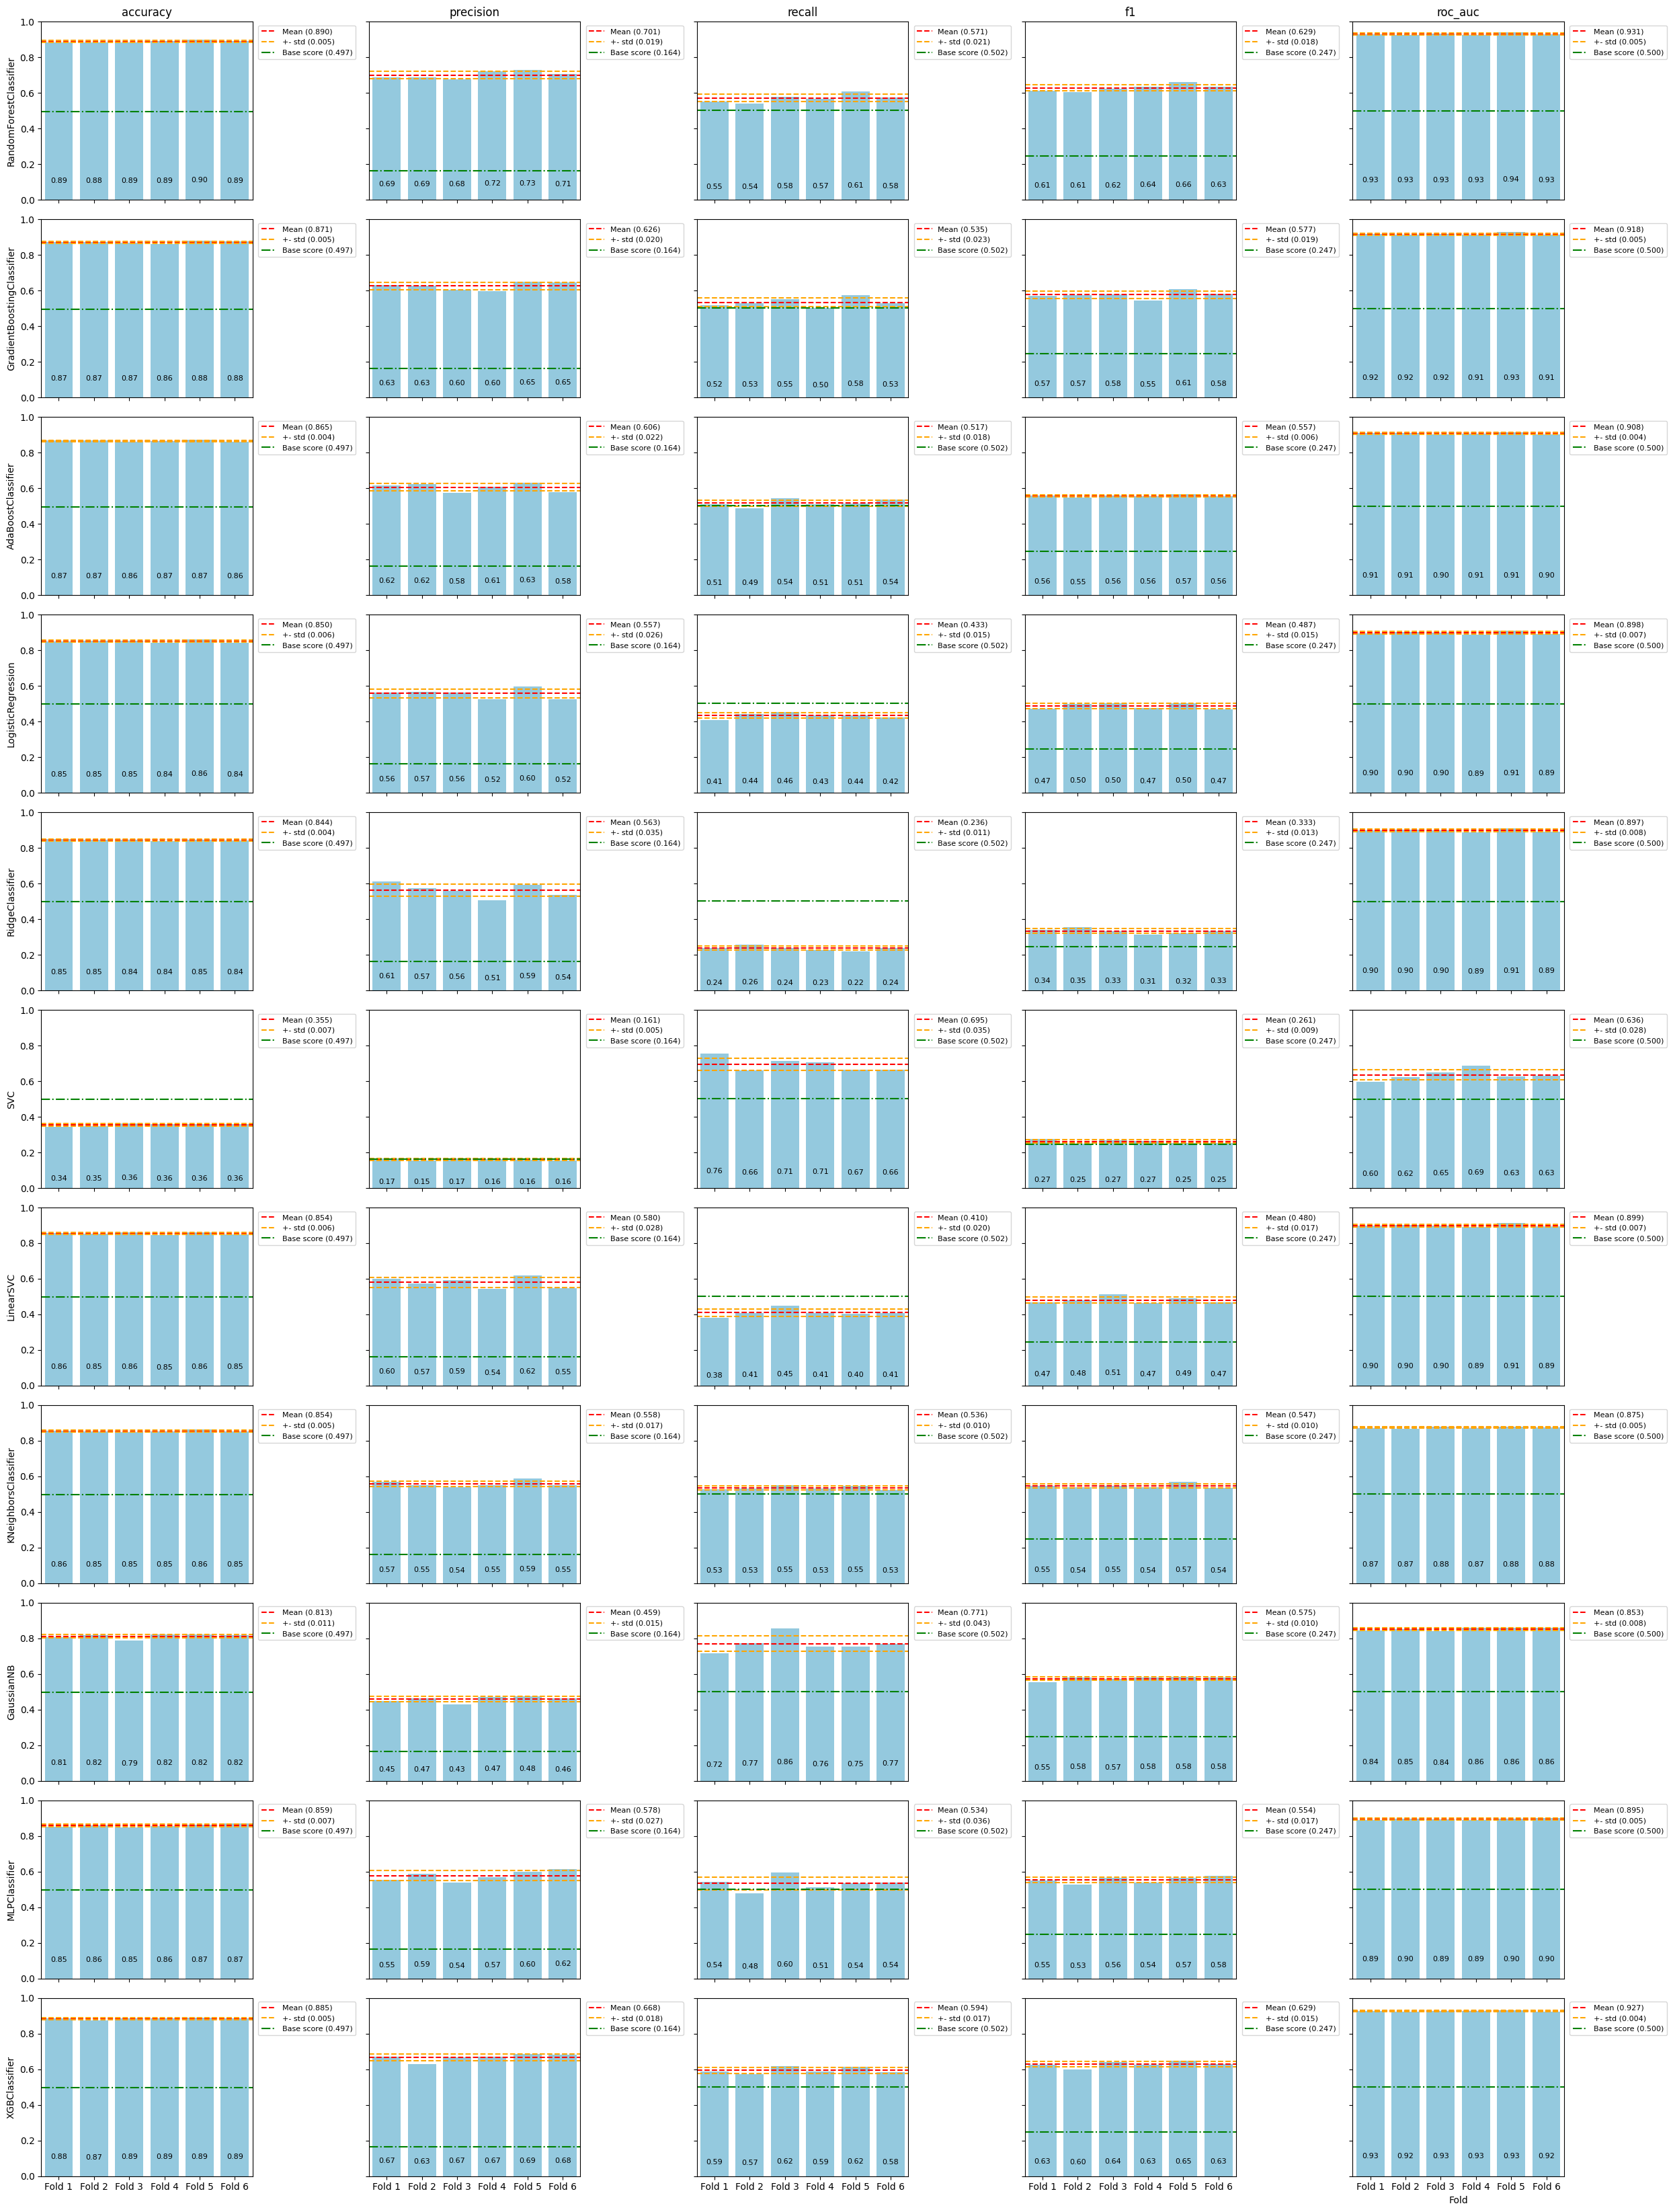

In [212]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 

models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(algorithm='SAMME'),
    LogisticRegression(max_iter=1000, dual=False),
    RidgeClassifier(),
    SVC(max_iter=1000),
    LinearSVC(dual=False, max_iter=1000),
    KNeighborsClassifier(),
    GaussianNB(),
    MLPClassifier(max_iter=1000),
    XGBClassifier()
]

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

scores = my_cross_validate(models, X_train, y_train, scoring=scoring)

<Figure size 1200x800 with 0 Axes>

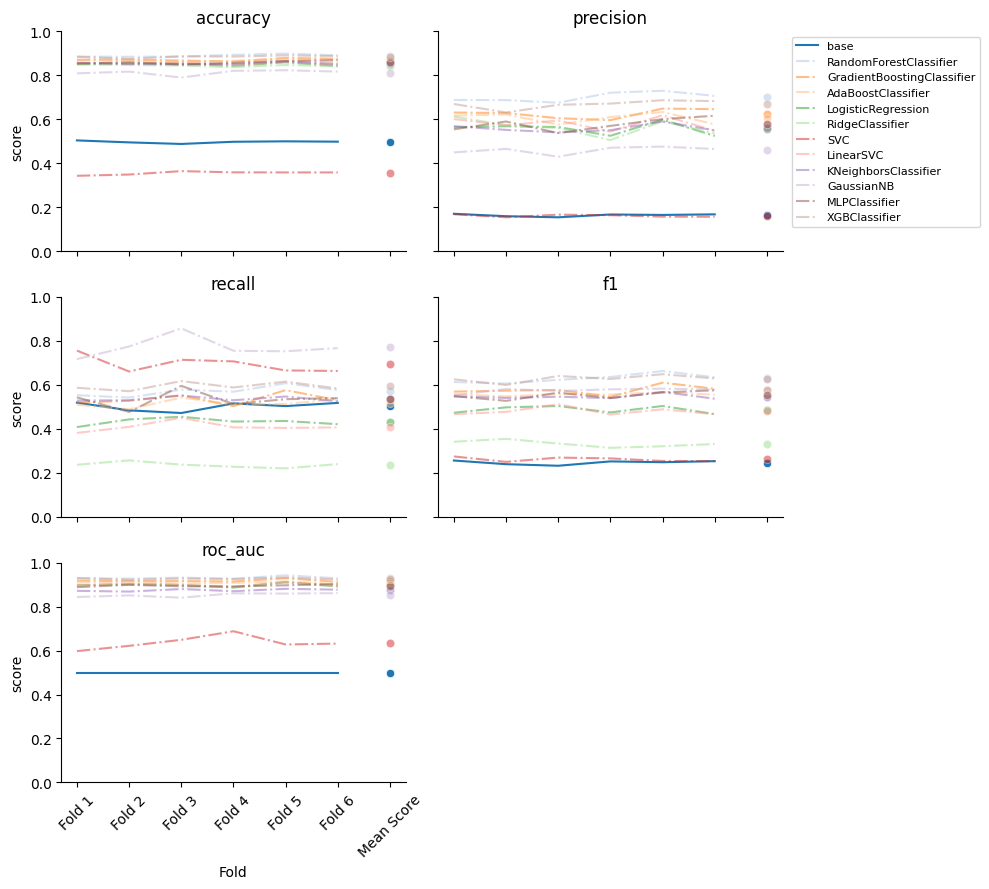

In [213]:
def plot_scoring(scoring, scores):
    plt.figure(figsize=(12, 8))
    sns.set_palette(sns.color_palette("tab20"))

    cv = len(list(scores.values())[0][1][1])
    rows = int(np.ceil(len(scoring) / 2))
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for model_name, model_scores in scores.items():
        for i, (metric_name, metric_scores) in enumerate(model_scores):
            linestyle='-.'
            alpha=0.5
            if model_name == "base":
                linestyle = "-"
                alpha=1
            sns.lineplot(x=range(len(metric_scores)), y=metric_scores, label=f'{model_name}', ax=axes[i], linestyle=linestyle, alpha=alpha)
    
            sns.scatterplot(x=[len(metric_scores)], y=[np.mean(metric_scores)], ax=axes[i], alpha=alpha)

    for i in range(len(scoring)):
        for j, (model_name, _) in enumerate(scoring.items()):
            axes[j].set_title(f"{model_name}")
            
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False) 
        axes[i].set_ylim(0, 1)
        axes[i].get_legend().remove()
        axes[i].set_xlabel('Fold')
        axes[i].set_ylabel('score')
        
        axes[i].set_xticklabels([f'Fold {i+1}' if i < cv else 'Mean Score' for i in range(-1, cv + 1)])
        axes[i].tick_params(axis='x', rotation=45)
        
    axes[min(len(scoring) - 1, cols - 1)].legend(fontsize=8, bbox_to_anchor=(1.01, 1), loc='upper left')

    for i in range(rows * cols, len(scoring), -1):
        axes[i - 1].axis('off')

    plt.tight_layout()
    plt.show()
    
plot_scoring(scoring, scores)

Science we predict whether client will be granted with a credit, we're more interested with high recall not high precision - after all, we'd prefer to guess that more people will be granted one than to discourage them from trying to.

In [6]:
# Initialize stratified k-fold
kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

# Initialize a variable to keep track of fold number
fold = 1

# Iterate over each fold
for train_index, test_index in kf.split(X_train, y_train):
    print('Fold {} of {}'.format(fold, kf.n_splits))
    
    # Split data into train and validation sets
    xtr, xvl = X_train.iloc[train_index], X_train.iloc[test_index]
    ytr, yvl = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Initialize and train the decision tree classifier
    model = DecisionTreeClassifier(random_state=1)
    model.fit(xtr, ytr)
    
    # Make predictions on the validation set
    pred_val = model.predict(xvl)
    
    # Calculate and print accuracy score
    score = accuracy_score(yvl, pred_val)
    print('Accuracy Score:', score)
    
    # Increment fold number
    fold += 1


NameError: name 'StratifiedKFold' is not defined

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the random forest classifier on the entire training set
rf_model = RandomForestClassifier(class_weight='balanced', random_state=1)
rf_model.fit(X_train, y_train)

# Make predictions on the validation set
rf_pred_val = rf_model.predict(X_val)

# Calculate accuracy score on the validation set
rf_val_score = accuracy_score(y_val, rf_pred_val)
print('Random Forest Validation Accuracy Score:', rf_val_score)


Random Forest Validation Accuracy Score: 0.8757341576506955


In [ ]:
# Initialize and train the decision tree classifier on the entire training set
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)

# Make predictions on the validation set
pred_val = model.predict(X_val)

# Calculate accuracy score on the validation set
val_score = accuracy_score(y_val, pred_val)x
print('Validation Accuracy Score:', val_score)


Validation Accuracy Score: 0.8528593508500772


In [ ]:
# Initialize and train the decision tree classifier on the entire training set
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)

# Make predictions on the validation set
pred_val = model.predict(X_val)

# Calculate accuracy score on the validation set
val_score = accuracy_score(y_val, pred_val)x
print('Validation Accuracy Score:', val_score)


Validation Accuracy Score: 0.8528593508500772


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the logistic regression classifier on the entire training set
logistic_model = LogisticRegression(random_state=1)
logistic_model.fit(X_train, y_train)

# Make predictions on the validation set
logistic_pred_val = logistic_model.predict(X_val)

# Calculate accuracy score on the validation set
logistic_val_score = accuracy_score(y_val, logistic_pred_val)
print('Logistic Regression Validation Accuracy Score:', logistic_val_score)


Logistic Regression Validation Accuracy Score: 0.8537867078825347


In [ ]:
import xgboost as xgb

# Convert the DataFrame into DMatrix format (required for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set hyperparameters for XGBoost
params = {
    'objective': 'binary:logistic',  # Use binary classification
    'eval_metric': 'error',           # Evaluate using classification error
    'seed': 1                         # Set random seed for reproducibility
}

# Train the XGBoost model
num_rounds = 436  # Number of boosting rounds (you can tune this hyperparameter)
xgb_model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the validation set
xgb_pred_val = xgb_model.predict(dval)
xgb_pred_val_binary = [1 if p > 0.5 else 0 for p in xgb_pred_val]

# Calculate accuracy score on the validation set
xgb_val_score = accuracy_score(y_val, xgb_pred_val_binary)
print('XGBoost Validation Accuracy Score:', xgb_val_score)

XGBoost Validation Accuracy Score: 0.887789799072643


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
xgb_conf_matrix = confusion_matrix(y_val, xgb_pred_val_binary)
xgb_conf_matrix
# Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('XGBoost Confusion Matrix')
# plt.show()


array([[2576,  158],
       [ 205,  296]], dtype=int64)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the Gradient Boosting Classifier on the entire training set
gb_model = GradientBoostingClassifier(random_state=1)
gb_model.fit(X_train, y_train)

# Make predictions on the validation set
gb_pred_val = gb_model.predict(X_val)

# Calculate accuracy score on the validation set
gb_val_score = accuracy_score(y_val, gb_pred_val)
print('Gradient Boosting Classifier Validation Accuracy Score:', gb_val_score)


Gradient Boosting Classifier Validation Accuracy Score: 0.8686244204018547


In [ ]:
# Training data
y_train = df['FINALIZED_LOAN']
X_train = df.drop(columns="FINALIZED_LOAN")

In [ ]:
# Initialize stratified k-fold
kf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

# Initialize a variable to keep track of fold number
fold = 1

# Iterate over each fold
for train_index, test_index in kf.split(X_train, y_train):
    print('Fold {} of {}'.format(fold, kf.n_splits))
    
    # Split data into train and validation sets
    xtr, xvl = X_train.iloc[train_index], X_train.iloc[test_index]
    ytr, yvl = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Initialize and train the decision tree classifier
    model = RandomForestClassifier(random_state=1)
    model.fit(xtr, ytr)
    
    # Make predictions on the validation set
    pred_val = model.predict(xvl)
    
    # Calculate and print accuracy score
    score = accuracy_score(yvl, pred_val)
    print('Accuracy Score:', score)
    
    # Increment fold number
    fold += 1


Fold 1 of 10
Accuracy Score: 0.890728476821192
Fold 2 of 10
Accuracy Score: 0.8920529801324504
Fold 3 of 10
Accuracy Score: 0.8880794701986755
Fold 4 of 10
Accuracy Score: 0.8986754966887417
Fold 5 of 10
Accuracy Score: 0.8986754966887417
Fold 6 of 10
Accuracy Score: 0.8980132450331125
Fold 7 of 10
Accuracy Score: 0.8933774834437086
Fold 8 of 10
Accuracy Score: 0.8933068257123923
Fold 9 of 10
Accuracy Score: 0.8840291583830351
Fold 10 of 10
Accuracy Score: 0.8913187541418157


In [ ]:
# Initialize stratified k-fold
kf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

# Initialize a variable to keep track of fold number
fold = 1

# Iterate over each fold
for train_index, test_index in kf.split(X_train, y_train):
    print('Fold {} of {}'.format(fold, kf.n_splits))
    
    # Split data into train and validation sets
    xtr, xvl = X_train.iloc[train_index], X_train.iloc[test_index]
    ytr, yvl = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Initialize and train the decision tree classifier
    model = RandomForestClassifier(random_state=1)
    model.fit(xtr, ytr)
    
    # Make predictions on the validation set
    pred_val = model.predict(xvl)
    
    # Calculate and print accuracy score
    score = f1_score(yvl, pred_val)
    print('Accuracy Score:', score)
    
    # Increment fold number
    fold += 1

NameError: name 'StratifiedKFold' is not defined